In [1]:
from langgraph_supervisor import create_supervisor
from pydantic import BaseModel, Field
from typing import Annotated, ClassVar, Sequence, TypedDict, Optional,Literal, Dict,Any
from langchain_core.messages import BaseMessage
from langgraph.graph import add_messages
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
import json
import os
from langgraph.managed import RemainingSteps
from langgraph.graph import START, StateGraph, END 
from IPython.display import Image, display
import requests

#1. light, TV, ve general devices 
PowerStatus = Literal["on", "off", "unknown"]
powerAction = Literal["on", "off"]

# 2.(Door)
LockStatus = Literal["locked", "unlocked", "unknown"]
LockAction = Literal["lock", "unlock"]

# 3. Perde ve Vana için
OpenCloseStatus = Literal["open", "closed", "unknown"]
OpenCloseAction = Literal["open", "close"]

# (Curtains)
#MotionStatus = Literal["open", "closed", "opening", "closing", "stopped", "unknown"]

# (AC, Heater)
HvacStatus = Literal["off", "cool", "heat", "fan_only", "auto", "unknown"]
HvacAction = Literal["set_mode_off", "set_mode_cool", "set_mode_heat", "set_mode_fan_only", "set_mode_auto"]



class AgentState(TypedDict):
    light: PowerStatus
    door_lock: LockStatus
    curtain: OpenCloseStatus
    tv: PowerStatus
    #termostat and AC combined
    thermostat_mode: HvacStatus
    main_water_valve: OpenCloseStatus
    messages: Annotated[Sequence[BaseMessage], add_messages]
    remaining_steps: RemainingSteps

load_dotenv()

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.5
)

user_memory_file = "user_memory.txt"
memory = ""

try:
    # Check if the file exists
    if os.path.exists(user_memory_file):
        # If the file exists, open it in 'r' (read) mode
        with open(user_memory_file, "r", encoding="utf-8") as f:
            memory = f.read()
        print(f"Loaded existing memory from '{user_memory_file}'.")
    else:
        print(f"'{user_memory_file}' file not found. Initializing memory as empty.")
        
except IOError as e:
    print(f"File read error: {e}. Initializing memory as empty.")
except Exception as e:
    print(f"An unexpected error occurred (reading): {e}. Initializing memory as empty.")

rules_file = "rules_file.txt"
current_rules_content = "{}"

try:
    if os.path.exists(rules_file):
        with open(rules_file, "r", encoding="utf-8") as f:
            content = f.read().strip()
            if content:
                current_rules_content = content
        print(f"Rules Agent: Loaded existing rules.")
    else:
        print(f"Rules Agent: '{rules_file}' not found. Starting fresh.")
        
except Exception as e:
        print(f"Rules Agent: Error reading file: {e}")

Loaded existing memory from 'user_memory.txt'.
Rules Agent: Loaded existing rules.


# 1.Home System Agent(SubAgent)

#### Tools
1. ışık aç/kapa
2. kapıyı kilitle/kiliti kaldır
3. perdeyi aç/kapa
4. televizyonu aç/kapa
5. klimayı aç/kapa
6. ısıtıcıyı aç/kapa
7. su aç/kapa

In [2]:
HOME_DB = {
    "light": "off",
    "tv": "off",
    "curtain": "closed",
    "door_lock": "locked",
    "thermostat_mode": "off",
    "main_water_valve": "closed"
}

In [3]:
def update_home_db(device_id: str, value: str):
    if device_id in HOME_DB:
        HOME_DB[device_id] = value
    else:
        # Eşleşmeyen isimler için (örn: main_thermostat -> thermostat_mode) manuel map
        if "thermostat" in device_id: HOME_DB["thermostat_mode"] = value
        if "door" in device_id: HOME_DB["door_lock"] = value
        # ...

## Light Tool

In [4]:
@tool
def control_light(device_id: str, action: powerAction) -> str:
    """
    Controls a light fixture by turning it 'on' or 'off'.
    This tool *only* sends the command; it does not check the current state.

    Args:
        device_id (str): The identifier for the light (e.g., 'living_room_light', 'kitchen_light').
        action (powerAction): The desired action, must be 'on' or 'off'.

    Returns:
        str: A JSON formatted string containing 'device_id', 'action', and a 'message'.
    """
    print(f"\n*** TOOL WORKED: control_light(device_id={device_id}, action={action}) ***")
  

    result_data = {
        "device_id": device_id,
        "action": action,
        "message": f"I have turned {action} the {device_id}."
    }
    return json.dumps(result_data)

## Door Lock Tool

In [5]:
@tool
def control_lock(device_id: str, action: LockAction) -> str:
    """
    Controls a door lock by setting it to 'lock' or 'unlock'.
    This tool *only* sends the command; it does not check the current state.

    Args:
        device_id (str): The identifier for the lock (e.g., 'front_door_lock').
        action (LockAction): The desired action, must be 'lock' or 'unlock'.

    Returns:
        str: A JSON formatted string containing 'device_id', 'action', and a 'message'.
    """
    print(f"\n*** TOOL WORKED: control_lock(device_id={device_id}, action={action}) ***")
    
    action_val = action.value if hasattr(action, "value") else str(action)
    
    if action_val == "lock":
        message = f"I have locked the {device_id}."
    else:
        message = f"I have unlocked the {device_id}."


    result_data = {
        "device_id": device_id,
        "action": action,
        "message": message
    }
    return json.dumps(result_data)

## Curtain Tool

In [6]:
@tool
def control_curtain(device_id: str, action: OpenCloseAction) -> str:
    """
    Controls curtains or blinds by setting them to 'open' or 'close'.
    This tool *only* sends the command; it does not check the current state.

    Args:
        device_id (str): The identifier for the curtain (e.g., 'living_room_curtain').
        action (OpenCloseAction): The desired action, must be 'open' or 'close'.

    Returns:
        str: A JSON formatted string containing 'device_id', 'action', and a 'message'.
    """
    print(f"\n*** TOOL WORKED: control_curtain(device_id={device_id}, action={action}) ***")
    if action == "open":
        message = f"I have opened the {device_id}."
    else:
        message = f"I have closed the {device_id}."
    
    result_data = {
        "device_id": device_id,
        "action": action,
        "message": message
    }
    return json.dumps(result_data)

## TV Tool

In [7]:
@tool
def control_tv(device_id: str, action: powerAction) -> str:
    """
    Controls a television by turning it 'on' or 'off'.
    This tool *only* sends the 'on' or 'off' command.

    Args:
        device_id (str): The identifier for the TV (e.g., 'living_room_tv').
        action (powerAction): The desired action, must be 'on' or 'off'.

    Returns:
        str: A JSON formatted string containing 'device_id', 'action', and a 'message'.
    """
    print(f"\n*** TOOL WORKED: control_tv(device_id={device_id}, action={action}) ***")
    
    if action == "on":
        message = f"I have turned on the {device_id}."
    else:
        message = f"I have turned off the {device_id}."
    result_data = {
        "device_id": device_id,
        "action": action,
        "message": message
    }
    return json.dumps(result_data)



## Thermostat Tool

In [8]:
@tool
def control_thermostat(action: HvacAction) -> Dict[str, Any]:
    """
    Controls the central thermostat by setting its operation mode.
    Assumes a single, central thermostat (no device_id needed).

    Args:
        action (HvacAction): The desired mode, e.g., "set_mode_off", "set_mode_cool", "set_mode_heat", "set_mode_fan_only", "set_mode_auto"

    Returns:
        str: A human-readable confirmation message.
    """
    print(f"\n*** TOOL WORKED: control_thermostat(action={action}) ***")
    
    mode = action.split('_')[-1] 
    #return f"The thermostat mode has been set to {mode}."
    message = f"I have set the thermostat mode to {mode}."
    
    result_data = {
        "device_id": "Main_Thermostat",
        "action": action,
        "message": message
    }
    return json.dumps(result_data)




## Water Valve Tool

In [9]:
@tool
def control_water_valve(device_id: str, action: OpenCloseAction) ->str:
    """
    Controls a water valve by setting it to 'open' or 'close'.
    This tool *only* sends the command; it does not check the current state.

    Args:
        device_id (str): The identifier for the valve (e.g., 'main_water_valve').
        action (OpenCloseAction): The desired action, must be 'open' or 'close'.

    Returns:
         str: A JSON formatted string containing 'device_id', 'action', and a 'message'.
    """
    print(f"\n*** TOOL WORKED: control_water_valve(device_id={device_id}, action={action}) ***")
    
    if action == "open":
        message = f"I have opened the {device_id}."
    else:
        message = f"I have closed the {device_id}."

    result_data = {
        "device_id": device_id,
        "action": action,
        "message": message
    }
    return json.dumps(result_data)


## Unsupported Action Tool

In [10]:
@tool
def notify_unsupported_action(request: str, reason: str) -> str:
    """
    Call this tool ONLY when the user asks for something you cannot do (e.g., make coffee, fly to moon).
    
    Args:
        request (str): The action user asked for (e.g., "make coffee").
        reason (str): Why you can't do it (e.g., "I don't have a coffee machine").
    Returns:
         str: A JSON formatted string containing 'device_id', 'action', and a 'message'.
    """
    print(f"⚠️ [NOTIFICATION] Cannot fulfill: {request}")
    
    message = f"I cannot {request} because {reason}."
    
    return json.dumps({
        "device_id": "system",
        "action": "notify",
        "message": message,
    })

In [11]:
home_system_tools = [control_light,
    control_lock,
    control_curtain,
    control_tv,
    control_thermostat,
    control_water_valve,
    notify_unsupported_action
]

home_system_llm = llm.bind_tools(home_system_tools)

In [12]:
from langchain_core.messages import ToolMessage, AIMessage, SystemMessage, HumanMessage

def home_system_agent(state: AgentState) -> dict:
    """
    Responsible for executing immediate commands to control smart home devices.
    
    Trigger this agent ONLY when the user wants to change the physical state of:
    - Lights (turn on/off)
    - TV (turn on/off)
    - Curtains/Blinds (open/close)
    - Door Locks (lock/unlock)
    - Thermostat (set mode/temperature)
    - Main Water Valve (open/close)

    Capabilities:
    - Checks the current state (HOME_DB) to avoid redundant actions.
    - Handles predefined automation modes that affect these devices.
    
    Do NOT use for:
    - Creating or editing automation rules.
    - Updating user profile/memory.
    """
    
    light = HOME_DB["light"]
    tv = HOME_DB["tv"]
    curtain = HOME_DB["curtain"]
    door_lock = HOME_DB["door_lock"]
    thermostat_mode = HOME_DB["thermostat_mode"]
    main_water_valve = HOME_DB["main_water_valve"]

    rules_content = "{}"
    try:
        if os.path.exists("rules_file.txt"):
            with open("rules_file.txt", "r", encoding="utf-8") as f:
                read_content = f.read().strip()
                if read_content:
                    rules_content = read_content
    except Exception as e:
        print(f"Home Agent Warning: Could not read rules file: {e}")



    system_prompt = f"""You are a precise smart home automation agent.

# 1. TRUTH: CURRENT DEVICE STATE
- Light: {light}
- Door Lock: {door_lock}
- Curtain: {curtain}
- TV: {tv}
- Thermostat Mode: {thermostat_mode}
- Main Water Valve: {main_water_valve}

# 1.5. KNOWLEDGE BASE: AUTOMATION MODES
If the user asks for a Mode (e.g. "Good Night"), use these definitions:
{rules_content}

# 2. DEVICE ID MAPPING
Use ONLY: 'light', 'door_lock', 'curtain', 'tv', 'main_thermostat', 'main_water_valve'.

# 3. EXECUTION ALGORITHM (MANDATORY)
You must process the user's request using this exact 3-step logic for EVERY device mentioned:

Step 1: Identify ALL devices mentioned in the user's request.
Step 2: For EACH device, compare "Current State" vs "Desired State":
**YOU HAVE TO PROVE** that (Current State != Desired State) before calling any tool.
   - IF (Current == Desired) -> **IGNORE** (Do nothing).
   - IF (Current != Desired) -> **ADD TO QUEUE** (Call the tool).
Step 3: Final Decision:
   - **IF Queue has tools:** Call them immediately.
      
# 4. HANDLING UNSUPPORTED REQUESTS
If a request is physically impossible (e.g., "Make coffee", "Play music"):
- Call `notify_unsupported_action(request=..., reason=...)`.

# 5. EXAMPLE LOGIC
User: "Turn off light (currently off) and TV (currently on)."
- Light: Off == Off -> Ignore.
- TV: On != Off -> **Call control_tv(action='off').**
Result: Only call TV tool.

User Request:"""

    messages = state["messages"]
    executed_tool_outputs = []
    
    for msg in reversed(messages):
        if isinstance(msg, ToolMessage):
            if msg.name and "transfer" in msg.name: #supervisor agentin gonderdigi toolmessageyi de ev cihazlari toollarindan geldi zannediyor bunu engellemek icin ekledim.
                break
            executed_tool_outputs.append(msg)
        else:
            break
    
    if executed_tool_outputs:
        response_sentences = []


        for tool_msg in reversed(executed_tool_outputs):
            try:
                content = json.loads(tool_msg.content)
                
                user_text = content.get("message", f"Action completed for {content.get('device_id')}.")
                response_sentences.append(user_text)

                device_id = str(content.get("device_id", "")).lower()
                action = str(content.get("action", "")).lower()

                if "set_mode_" in action: action = action.split("_")[-1]
                if "lock" == action: action = "locked"
                if "unlock" == action: action = "unlocked"
                if "close" == action: action = "closed"
                if "open" == action: action = "open"


                update_home_db(device_id, action)

                #if "light" in device_id: 
                #    HOME_DB["light"] = action
                #
                #elif "tv" in device_id: 
                #    HOME_DB["tv"] = action
                #
                #elif "curtain" in device_id or "blind" in device_id: 
                #    HOME_DB["curtain"] = action
                #
                #elif "door" in device_id or "lock" in device_id: 
                #    HOME_DB["door_lock"] = action
                #
                #elif "thermostat" in device_id or "hvac" in device_id: 
                #    HOME_DB["thermostat_mode"] = action
                #
                #elif "valve" in device_id or "water" in device_id: 
                    #HOME_DB["main_water_valve"] = action


            except json.JSONDecodeError:
                response_sentences.append("Task completed.")

        final_response = " ".join(response_sentences)
        
        return {"messages": [AIMessage(content=final_response, name="home_operations")]}


    
    user_msg = next((msg.content for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)),None)
    
    
    if not user_msg:
        return {"messages": [AIMessage(content="I'm ready. What can I help you with?", name="home_operations")]}
        
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_msg)
    ]

    response = home_system_llm.invoke(messages)

    print(f"home agent message: {response}")
    return {
        "messages": [response]
    }

In [13]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(home_system_tools)

from langgraph.graph import START, StateGraph, END

def should_continue(state: AgentState) -> str:
    """
    Decides whether to continue the workflow or end it.
    If the last AIMessage contains a tool call, continue to the tool node.
    Otherwise, end the workflow.
    """
    last_message = state["messages"][-1] if state["messages"] else None

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"  # Continue to the tool node
    else:
        return END     # End the workflow

    
workflow = StateGraph(AgentState)

workflow.add_node("agent", home_system_agent) 
workflow.add_node("tools", tool_node)

workflow.add_edge(START,"agent") 

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools", 
        END: END         
    }
)

workflow.add_edge("tools", "agent")

home_operations = workflow.compile(
    name="home_operations")

# 2.User Memory Agent(SubAgent)

In [ ]:
def load_user_memory(user_memory_file="user_memory.txt"):
    """
    Belirtilen dosyadan hafızayı okur ve string olarak döndürür.
    Hata durumunda veya dosya yoksa boş string döner.
    """
    memory = ""

    try:
        if os.path.exists(user_memory_file):
            with open(user_memory_file, "r", encoding="utf-8") as f:
                memory = f.read()
            print(f"Loaded existing memory from '{user_memory_file}'.")
        else:
            print(f"'{user_memory_file}' file not found. Initializing memory as empty.")
            
    except IOError as e:
        print(f"File read error: {e}. Initializing memory as empty.")
    except Exception as e:
        print(f"An unexpected error occurred (reading): {e}. Initializing memory as empty.")
    
    return memory

In [ ]:
def user_memory(state: 'AgentState'): 
    """
    This agent is responsible for meticulously managing the "CURRENT USER INFORMATION" (user memory)
    based on the ongoing conversation history. Its primary function is to identify, consolidate,
    and store factual, personal, or preference-based information about the user derived from
    their recent input.
    """
    user_memory_file = "user_memory.txt"
    memory = load_user_memory(user_memory_file)

    memory_prompt = """
    You are collecting information about the user from user query and add information to "CURRENT USER INFORMATION"(If it exists) if there is new information about user.

    CURRENT USER INFORMATION(may be empty):
    {memory}

    INSTRUCTIONS:
    1. Review the chat history below carefully
    2. Identify new information about the user, such as:
        - Personal details (name, location, e.g.)
        - Preferences (likes, dislikes)
        - Interests and hobbies
        - Past experiences
    **3. Compare the identified information with the CURRENT USER INFORMATION.**
    **4. If no new or different information is found, output the CURRENT USER INFORMATION exactly as is.**
    **5. If new information *is* found:**
        **a.** Merge any new information with existing memory.
        **b.** If new information conflicts with existing memory, keep the most recent version.
        **c.** Format the *updated* memory as a clear, bulleted list.

    Important: Do NOT include summaries like "no update needed". Dont add your command.
    Your response must be in text format
    If no new data is available in user message, return the user information unmodified. Like this(may be empty):
    {memory}
    """

    user_msg = next((msg.content for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)),None) 

    system_prompt = SystemMessage(content=memory_prompt.format(memory=memory))

    rs = llm.invoke([system_prompt, user_msg]) 

    try:
        content_to_write = str(rs.content)

        with open(user_memory_file, "w", encoding="utf-8") as f:
            f.write(content_to_write)
        
        print(f"Success: New response was written and saved to '{user_memory_file}'.")
        return {"messages": [AIMessage(content="Success: New response was written and saved", name="add_user_info")]}

    except IOError as e:
        print(f"File write error: {e}")
    except AttributeError:
         print(f"Error: Failed to get 'content' from LLM response. Response was: {rs}")
    except Exception as e:
        print(f"An unexpected error occurred (writing): {e}")

In [16]:
graph = StateGraph(AgentState)

graph.add_node("user_memory", user_memory)

graph.add_edge(START, "user_memory")
graph.add_edge("user_memory", END)

add_user_info = graph.compile(name="add_user_info")

The `add_user_info` subagent is designed for **user memory management**. Its sole purpose is to **review the chat history**, identify new or updated personal details, preferences, or interests shared by the user, and **update the "CURRENT USER INFORMATION"** accordingly.

**IMPORTANT:** The supervisor agent must call `add_user_info` **only** when the user's latest query or response contains **new, non-trivial, or updated factual information** about themselves (e.g., name, location, hobby, preference). Avoid calling it for simple conversational turns, acknowledgments, or requests that don't add to the user's profile.

# 3.Rule Agent(SubAgent)

In [ ]:
class OperationsSchema(BaseModel):
    home_operations: list[Literal[
        "turn on light", "turn off light", 
        "turn off tv", "turn on tv", 
        "lock door", "unlock door", 
        "close curtain", "open curtain", 
        "open water valve", "close water valve", 
        "turn on thermostat", "turn off thermostat"
    ]] = Field(
        description="List of specific home automation actions required for the user-defined routine. "
                    "Example: For 'Define Cinema Mode as a setting that turns off the lights and turns on the TV.', map to ['turn off light', 'turn on tv']."
    )
    operation_name: str = Field(
        description="The short name or trigger phrase for the operations defined by the user. "
                    "Example: 'Cinema Mode' or 'Night Routine'."
    )

class RuleAndOperation(BaseModel):
    rules: list[str] = Field(
        description="Permanent behavioral instructions or preferences the user wants you to remember."
                    "Example: 'Always speak formally to me' or 'Always ask me for approval before opening the door.'.",
        default_factory=list
    )
    operations: Optional[OperationsSchema] = Field(
        description="Schema to define a new home automation routine/macro if the user requests one."
    )

def rule_keeper(state: 'AgentState'): 
    """
    Responsible for creating, updating, or deleting automation rules and routines (macros).
    
    Trigger this agent ONLY when the user defines a FUTURE behavior or SCENARIO:
    1. Defining Routines/Modes: 
       - e.g., "Create 'Cinema Mode' that turns off lights and turns on TV."
       - e.g., "Update 'Morning Routine' to also open the curtains."
    2. Setting Persistent Rules: 
       - e.g., "Always ask for confirmation before unlocking the door."
       - e.g., "Never turn on the music after 10 PM."

    Capabilities:
    - Parses user intent into structured JSON (Operations & Rules).
    - Persists data to 'rules_operations.json'.
    - Merges new instructions with existing ones (Update/Overwrite logic).

    Do NOT use for:
    - Executing a command RIGHT NOW (e.g., "Turn on the light" -> use 'home_system_agent').
    - Queries about current device status.
    """
    rules_file = "rules_operations.json"

    default_data = {"rules": [], "operations": []}

    rules_data = default_data

    try:
        if os.path.exists(rules_file):
            with open(rules_file, "r", encoding="utf-8") as f:
                try:
                    file_content = json.load(f)
                    
                    if file_content:
                        rules_data = file_content
                        print(f"Rules Agent: Loaded existing rules from JSON.")
                    else:
                        print("Rules Agent: JSON file is empty. Using default structure.")
                        
                except json.JSONDecodeError:
                    print("Rules Agent: JSON decode error (file might be corrupted). Starting fresh.")
        else:
            print(f"Rules Agent: '{rules_file}' not found. Starting fresh.")
            
    except Exception as e:
        print(f"Rules Agent: Error reading file: {e}")

    current_rules_content = json.dumps(rules_data, ensure_ascii=False, indent=2)
        
    system_prompt_content = """
    You are the "Rule Manager" of a smart home system. 
    Your ONLY job is to maintain a persistent record of automation rules based on user commands.

    ### CURRENT DATABASE (JSON format):
    {current_rules_content}

    ### INSTRUCTIONS:
    1. Analyze the User's Input to identify the **Trigger** (e.g., "Cinema Mode", "I'm home") and the **Actions** (e.g., "Lights off", "TV on").

    2. **SEMANTIC MATCHING**
        - Before creating a new Trigger key, look at the CURRENT DATABASE keys.
        - If the user's trigger is semantically similar to an existing key (e.g., "Movie Mode" ≈ "Cinema Mood", "I'm back" ≈ "Welcome Home"), **USE THE EXISTING KEY**.

    3. **UPDATE LOGIC:**
        - If the Trigger is NEW: Create the entry.
        - If the Trigger EXISTS:
            a. **MERGE** the new actions with the existing actions.
            b. **DEDUPLICATE:** Remove exact duplicates (e.g., do NOT allow ["Light on", "Light on"]).
            c. **RESOLVE CONFLICTS:** If a NEW action conflicts with an OLD action (e.g., Old: "Light On", New: "Light Off"), the **NEW action overwrites** the old one.
            d. **CONTEXT AWARENESS:** If the user phrase implies a full definition (e.g., "When I say X, do A, B and C"), ensure the final list reflects exactly A, B, and C. Remove unrelated old actions if they seem contradictory to the new definition.
        
    4. **OUTPUT FORMAT:**
        - Output ONLY the updated JSON string. 
        - No markdown, no conversation, no explanations.
        - If the user input is unclear, return the CURRENT DATABASE unchanged.

    ### EXAMPLE:
    Current: {{"cinema mode": ["lights off", "tv on"]}}
    User: "For cinema mode, also close the curtains"
    Output: {{"cinema mode": ["lights off", "tv on", "close the curtains"]}}

    Current: {{"sleep mode": ["lights on"]}}
    User: "Change sleep mode to turn lights off"
    Output: {{"sleep mode": ["lights off"]}}
    """

    user_msg = next((msg.content for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage)), None)
    if not user_msg:
        return {"messages": [AIMessage(content="No user message found to process.")]}


    structured_llm = llm.with_structured_output(RuleAndOperation)

    system_prompt = SystemMessage(content=system_prompt_content.format(current_rules_content=current_rules_content))

    messages = [
        system_prompt,
        HumanMessage(content=user_msg)
    ]

    response_obj = structured_llm.invoke(messages)


    rules_file = "rules_operations.json" 

    if os.path.exists(rules_file):
        try:
            with open(rules_file, "r", encoding="utf-8") as f:
                current_data = json.load(f)
        except json.JSONDecodeError:
            current_data = {"rules": [], "operations": []}
    else:
        current_data = {"rules": [], "operations": []}

    # Key garantisi
    if "rules" not in current_data: current_data["rules"] = []
    if "operations" not in current_data: current_data["operations"] = []

    changes_log = []

    if response_obj.rules:
        added_count = 0
        for new_rule in response_obj.rules:
            if new_rule not in current_data["rules"]:
                current_data["rules"].append(new_rule)
                added_count += 1
        
        if added_count > 0:
            changes_log.append(f"Added {added_count} new rules.")

    if response_obj.operations:
        new_op_data = response_obj.operations.model_dump()
        new_op_name = new_op_data.get("operation_name")
        
        found_index = -1
        for i, existing_op in enumerate(current_data["operations"]):
            if existing_op.get("operation_name") == new_op_name:
                found_index = i
                break
        
        if found_index != -1:
            current_data["operations"][found_index] = new_op_data
            changes_log.append(f"Updated existing operation: '{new_op_name}'")
        else:
            current_data["operations"].append(new_op_data)
            changes_log.append(f"Created new operation: '{new_op_name}'")

    try:
        if changes_log:
            confirmation_msg = f"[SYSTEM_REPORT] Database updated successfully. {' '.join(changes_log)}"
            with open(rules_file, "w", encoding="utf-8") as f:
                json.dump(current_data, f, ensure_ascii=False, indent=4)
        else:
            confirmation_msg = f"[SYSTEM_REPORT] No new changes detected. The operation '{new_op_name}' already exists with these settings."
            
        print(f"Rules Agent: {confirmation_msg}")
        
        return {"messages": [AIMessage(content=confirmation_msg, name="rule_operations")]}

    except Exception as e:
        error_msg = f"[SYSTEM_REPORT] File write error: {e}"
        print(f"Rules Agent Error: {e}")
        return {"messages": [AIMessage(content=error_msg, name="rule_operations")]}

In [18]:
graph_rule = StateGraph(AgentState)

graph_rule.add_node("keep_user_rules", rule_keeper)

graph_rule.add_edge(START, "keep_user_rules")
graph_rule.add_edge("keep_user_rules", END)

rule_operations = graph_rule.compile(name="rule_operations")

kolay ve guzel gorunecek bir sekilde test etmek icin fonskiyon:

In [19]:
def run_query(str_input):
    inputs = {"messages": [HumanMessage(content=str_input)]}
    try:
        # Recursion limit: Sonsuz döngüyü engeller
        for s in agentt.stream(inputs, config={"recursion_limit": 7}):
            for agent_name, output in s.items():
                print(f"--- 🤖 {agent_name} ---")

                # Supervisor'ın kararını yazdır
                if "next" in output:
                    print(f"🔀 Rota: {output['next']}")

                # Mesaj varsa içeriğini göster
                if "messages" in output:
                    last_msg = output["messages"][-1]
                    if hasattr(last_msg, 'content') and last_msg.content:
                        print(f"💬 Mesaj: {last_msg.content}")

                    # Tool kullanımı varsa detay ver
                    if hasattr(last_msg, 'tool_calls') and len(last_msg.tool_calls) > 0:
                        print(f"🛠️ Tool: {last_msg.tool_calls[0]['name']}")
                        print(f"📝 Args: {last_msg.tool_calls[0]['args']}")

                print("------------------------------\n")

    except Exception as e:
        print(f"🛑 Hata oluştu: {e}")

# SUPERVISOR

## Weather Tool

In [ ]:
import requests
@tool
def get_weather() -> str:
    """
    Hava durumu bilgisini getirir.
    WMO kodlarını insan diline çevirerek döndürür.
    """
    city_name="Aydın"

    wmo_codes = {
        0: "Açık/Güneşli",
        1: "Çoğunlukla Açık",
        2: "Parçalı Bulutlu",
        3: "Kapalı",
        45: "Sisli",
        48: "Kırağı/Sis",
        51: "Hafif Çiseleme",
        53: "Çiseleme",
        55: "Yoğun Çiseleme",
        61: "Hafif Yağmurlu",
        63: "Yağmurlu",
        65: "Şiddetli Yağmur",
        71: "Hafif Kar Yağışlı",
        73: "Kar Yağışlı",
        75: "Yoğun Kar Yağışlı",
        77: "Kar Taneleri",
        80: "Hafif Sağanak",
        81: "Sağanak",
        82: "Şiddetli Sağanak",
        95: "Fırtına/Gök Gürültülü",
        96: "Dolu ve Fırtına",
        99: "Şiddetli Dolu ve Fırtına"
    }

    geo_url = "https://geocoding-api.open-meteo.com/v1/search"
    geo_params = {"name": city_name, "count": 1, "language": "tr", "format": "json"}
    
    try:
        geo_response = requests.get(geo_url, params=geo_params)
        geo_response.raise_for_status()
        geo_data = geo_response.json()
        
        if not geo_data.get("results"):
            return f"Hata: '{city_name}' bulunamadı."
            
        location = geo_data["results"][0]
        lat = location["latitude"]
        lon = location["longitude"]
        place_name = f"{location['name']}, {location.get('country', '')}"
        
    except Exception as e:
        return f"Hata (Konum): {str(e)}"

    weather_url = "https://api.open-meteo.com/v1/forecast"
    weather_params = {
        "latitude": lat,
        "longitude": lon,
        "current_weather": "true",
        "timezone": "auto"
    }
    
    try:
        w_response = requests.get(weather_url, params=weather_params)
        w_response.raise_for_status()
        w_data = w_response.json()
        
        current = w_data.get("current_weather", {})
        code = current.get('weathercode')
        
        condition_text = wmo_codes.get(code, "Bilinmiyor")
        
        result = {
            "konum": place_name,
            "sicaklik": f"{current.get('temperature')}°C",
            "ruzgar": f"{current.get('windspeed')} km/h",
            "durum": condition_text,  
        }
        
        return str(result)

    except Exception as e:
        return f"Hata (Hava Durumu): {str(e)}"

In [21]:
sup_template = """
You are a helpful Home Assistant Supervisor coordinating three specialists:
- **add_user_info**: saves NEW, long-term facts about the user (e.g., name, location, hobbies).
- **home_operations**: controls physical devices (lights, TV, curtain, door, thermostat, water valve). Examples: "Turn on lights", "Turn off tv".
- **rule_operations**: defines, updates, or deletes FUTURE automation rules or scenarios.

Your goal is to satisfy the user’s intent with minimal steps, avoiding unnecessary agent calls.

Context Data:
<user_memory>
{memory}
</user_memory>

<active_rules_and_ops>
{rule_and_operations}
</active_rules_and_ops>

Routing:
- If the user shares NEW factual info not already in `<user_memory>`, use `add_user_info`.
- If the user wants to control a device use `home_operations`(e.g. "Turn on lights", "Turn on tv"). 
- If the user wants to triggers an operation explicitly listed in `<active_rules_and_ops>`, use `home_operations`.
- If the user defines or edits logic for the FUTURE (e.g., "Create a mode", "Always do X when Y") or the user defines a new operation sequence or alias (e.g., "If I say 'Dark Mode', turn off the lights", "Define 'Cinema Mode' as closing curtains and turning on the TV"), use `rule_operations`.
- If the input is a greeting, general question, or simple acknowledgment, **DO NOT use tools**; reply directly using the context.

Guardrails:
- **Memory Check:** Do not use `add_user_info` for temporary states (e.g., "I am hungry") or information already present in memory.
- **Execution vs. Definition:** Distinguish clearly. "Turn on Cinema Mode" is `home_operations` (execution). "Define Cinema Mode" is `rule_operations` (definition).
- **Personalization:** Always check `<user_memory>` to tailor your response and adhere to any interaction rules in `<active_rules_and_ops>`.
- **Weather Tool Usage:** Invoke the `get_weather` tool not only for direct inquiries but also when the user implies outdoor context (e.g., 'I am going out,', 'I will walk to school.'). Use the retrieved data to provide proactive recommendations or safety advice.
"""

In [ ]:
def get_formatted_rules_and_operations(file_path="rules_operations.json"):
    """
    Belirtilen JSON dosyasından kuralları ve operasyonları okuyup
    okunaklı bir string formatında döndürür.
    """
    
    if not os.path.exists(file_path):
        return "Rules Agent: Dosya bulunamadı, henüz kural veya operasyon yok."

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            
        output_lines = []

        # --- RULES ---
        output_lines.append("RULES:")
        rules = data.get("rules", [])
        
        if rules:
            for rule in rules:
                output_lines.append(f"- {rule}")
        else:
            output_lines.append("- (Kayıtlı kural yok)")

        output_lines.append("") 

        # --- OPERATIONS ---
        output_lines.append("OPERATIONS:")
        operations = data.get("operations", [])
        
        if operations:
            for op in operations:
                name = op.get("operation_name", "Bilinmeyen Operasyon")
                actions_list = op.get("home_operations", [])
                actions_str = ", ".join(actions_list)
                
                output_lines.append(f"- {name} : {actions_str}")
        else:
            output_lines.append("- (Kayıtlı operasyon yok)")

        return "\n".join(output_lines)

    except json.JSONDecodeError:
        return "Rules Agent: Dosya formatı bozuk (JSON Hatası)."
    except Exception as e:
        return f"Rules Agent: Bir hata oluştu: {e}"

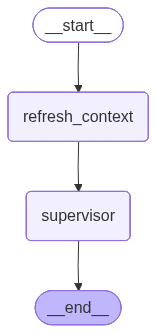

In [ ]:
def supervisor_context_node(state: AgentState):

    current_memory = load_user_memory()
    current_rules = get_formatted_rules_and_operations()

    dynamic_content = sup_template.format(
        memory=current_memory, 
        rule_and_operations=current_rules
    )
    
    return {
        "messages": [SystemMessage(content=dynamic_content)]
    }

supervisor = create_supervisor(
    agents=[add_user_info, home_operations, rule_operations],
    model=llm,
    tools=[get_weather],
    prompt="You are a smart home supervisor. Follow the instructions provided in the system context.",
    add_handoff_back_messages=True,
    output_mode="full_history"
)

builder = StateGraph(AgentState)

builder.add_node("refresh_context", supervisor_context_node)
builder.add_node("supervisor", supervisor.compile()) 

builder.add_edge(START, "refresh_context")
builder.add_edge("refresh_context", "supervisor")
builder.add_edge("supervisor", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
rs=graph.invoke({"messages": [HumanMessage(content="'VAY SAĞ SOL' der misin?")]})

Loaded existing memory from 'user_memory.txt'.


In [35]:
rs["messages"][-1].content[0]["text"]

'VAY SAĞ SOL'

In [ ]:
# pip install -U langgraph langgraph-supervisor langchain-core (Hata alırsan)

In [ ]:
#####################################################